# Курсовая работа по дисциплине "Технологии машинного обучения"

## 1) Поиск и выбор набора данных для построения моделей машинного обучения.

В качестве набора данных используем датасет с успеваемостью учеников на экзамене по разным предметам https://www.kaggle.com/spscientist/students-performance-in-exams

Датасет содержит следующие колонки:<br>
gender - пол ученика<br>
race/ethnicity - принадлежность ученика к одной из групп по рассе и национальности<br>
parental level of education - уровень образования родителей ученика<br>
lunch - какой обед получает ученик (стандартный или бесплатный)<br>
test preparation course - готовился ли ученик к экзамену<br>
math score - балл по математике<br>
reading score - балл за чтение<br>
writing score - балл за письмо<br>

Будем решать задачу классификации - предсказывать сдаст ли ученик экзамен по математике. Рассмотрим 2 случая: в первом будем предсказывать, используя только общую информацию, во втором - зная также его баллы за другие экзамены.

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных

In [2]:
data = pd.read_csv("StudentsPerformance.csv")

# 2) Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

Основные характеристики датасета

In [3]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
# Размер датасета
data.shape

(1000, 8)

In [5]:
# Список колонок с типами данных 
data.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [6]:
# Проверим на наличие пропусков в данных
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

Пропусков в данных нет. Построим графики для наглядности данных

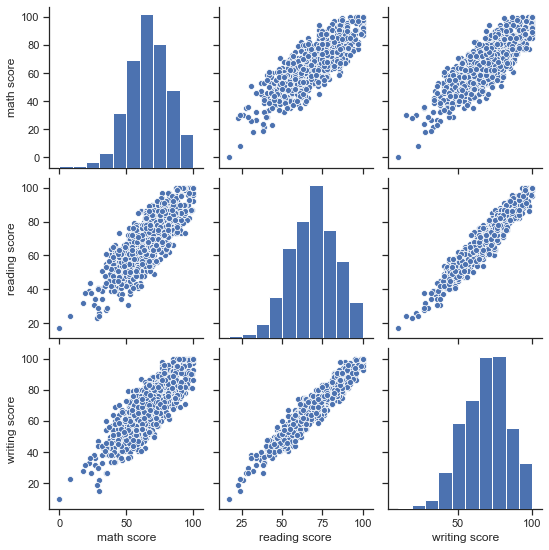

In [7]:
# Парные диаграммы
sns.pairplot(data)

Видим как распределены баллы по математике, чтению и письму и как они зависят друг от друга (почти линейно)

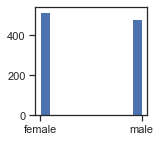

In [8]:
# Оценим дисбаланс классов для gender
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(data['gender'])
plt.show()

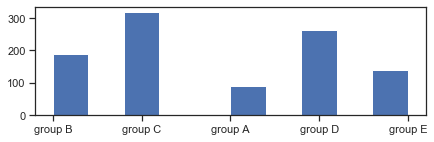

In [9]:
# Оценим дисбаланс классов для race/ethnicity
fig, ax = plt.subplots(figsize=(7,2)) 
plt.hist(data['race/ethnicity'])
plt.show()

Есть дисбаланс класов по признаку race/ethnicity, но он является приемлимым

# 3) Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

Мы уже видели, что оценки по разным дисциплинам зависят друг от друга, убедимся в этом еще раз

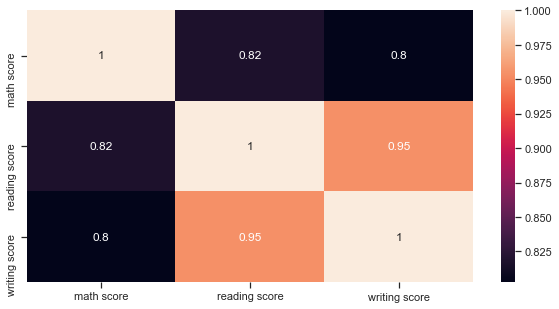

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)

Минимальное значение в таблице корреляций 0.8 само по себе велико, однако как мы видим оценки по математики коррелируют не так сильно, как коррелируют между собой чтение и письмо

Построим ящики с усами, чтобы посмотреть распределение баллов за экзамены в зависимости от пола и этнической группы

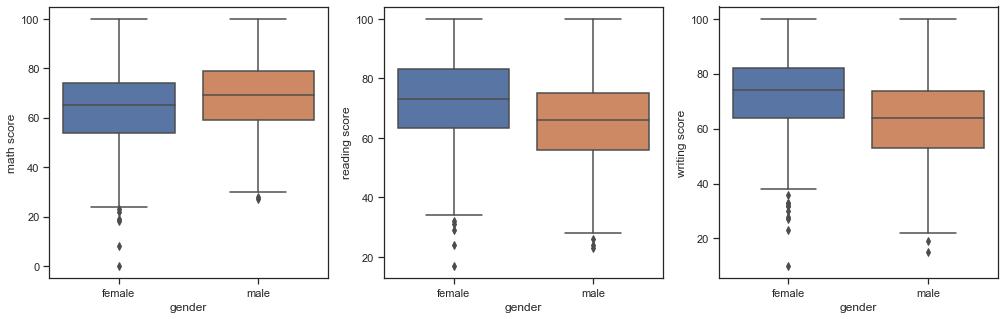

In [11]:
y_cols = ['math score', 'reading score', 'writing score']
fig = plt.figure(figsize=(17, 5))
n = 1
for y in y_cols:
    ax = fig.add_subplot(1, 3, n)
    g = sns.boxplot( x= 'gender', y = y, data = data)
    n += 1

Кажется пол влияет на успеваемость, внесем этот признак в модель

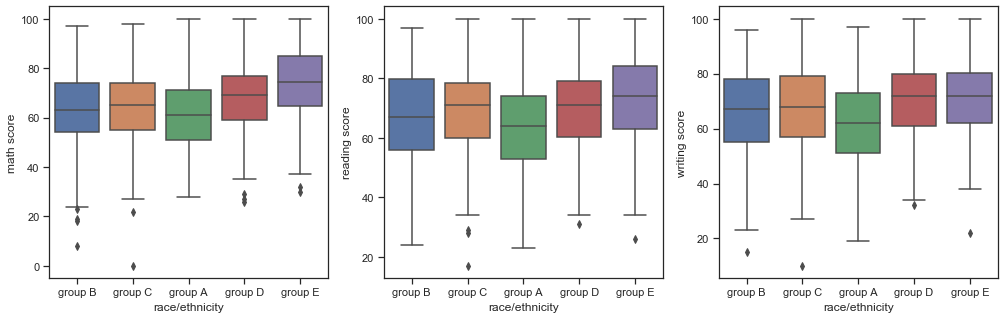

In [12]:
y_cols = ['math score', 'reading score', 'writing score']
fig = plt.figure(figsize=(17, 5))
n = 1
for y in y_cols:
    ax = fig.add_subplot(1, 3, n)
    g = sns.boxplot(x = 'race/ethnicity', y = y, data = data)
    n += 1

Тут также наблюдается некая зависимость, поэтому этот признак тоже используем

Посмотрим как зависит успеваемость учеников от уровня образования их родителей. Построим для этого heatmap

In [13]:
# Посмотрим уникальные значения в столбце
data['parental level of education'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

In [14]:
# Заменим 'some college' на 'college' и 'some high school' на 'high school'
data.loc[data['parental level of education']=='some college', 'parental level of education'] = 'college'
data.loc[data['parental level of education']=='some high school', 'parental level of education'] = 'high school'
data['parental level of education'].unique()

array(["bachelor's degree", 'college', "master's degree",
       "associate's degree", 'high school'], dtype=object)

In [15]:
# Строим таблицу, отражающую зависимость между уровнем образования родителей и средним баллом учеников
data_edu = pd.Series()
for education_level in data['parental level of education'].unique():
    mean = data[data["parental level of education"] == education_level].mean()
    mean = mean.rename(education_level)
    data_edu = pd.concat([data_edu, mean], axis = 1, sort = False)

data_edu = data_edu.drop(data_edu.columns[0], axis = 1)

data_edu
   

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,bachelor's degree,college,master's degree,associate's degree,high school
math score,69.389831,67.128319,69.745763,67.882883,62.786667
reading score,73.000000,69.460177,75.372881,70.927928,65.770667
writing score,73.381356,68.840708,75.677966,69.896396,63.613333


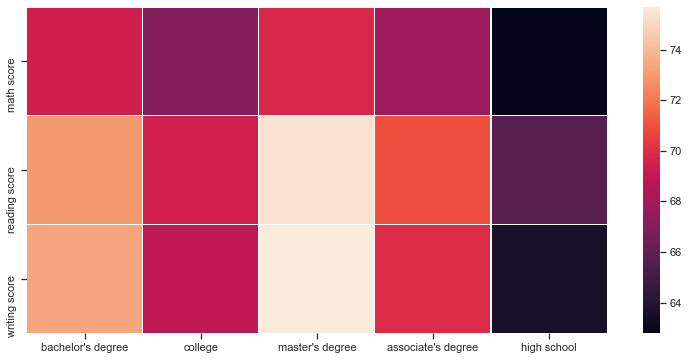

In [16]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(data_edu, linewidths=.1, ax=ax)

Видим, что чем выше степень образования у родителей, тем лучше ученики сдают экзамены. Корреляция довольно сильная, поэтому этот признак позволит построить модель классификации

Посмотрим, как зависит успеваемость учеников от типа обедов, которые они получают (как бы странно это ни было:))

In [17]:
# Строим таблицу, отражающую зависимость между типом обеда и средним баллом учеников

data_lunch = pd.Series()
for lunch_type in data['lunch'].unique():
    mean = data[data['lunch'] == lunch_type].mean()
    mean = mean.rename(lunch_type)
    data_lunch = pd.concat([data_lunch, mean], axis = 1, sort = False)

data_lunch = data_lunch.drop(data_lunch.columns[0], axis = 1)

data_lunch
   

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


,standard,free/reduced
math score,70.034109,58.921127
reading score,71.654264,64.653521
writing score,70.823256,63.022535


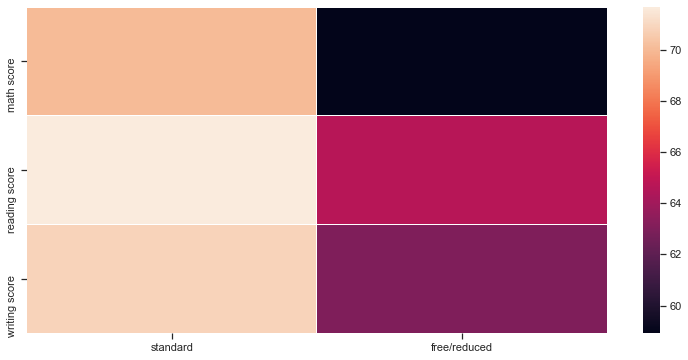

In [18]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(data_lunch, linewidths=.1, ax=ax)

Можно видеть, что ученики, получающие бесплатный обед, сдают экзамены хуже, чем ученики со стандартным обедом. Естественно обеды сами по себе не влияют на успеваемость, скорее всего это социологический вопрос, например эти ученики из многодетных или малоимущих семей. Данный признак также включаем в модель

И, наконец, посмотрим, как зависит успеваемость на экзамене от подготовки к нему.

In [19]:
# Строим таблицу, отражающую зависимость между средним баллом учеников, которые готовились к экзамену и нет

data_prep = pd.Series()
for prep in data['test preparation course'].unique():
    mean = data[data['test preparation course'] == prep].mean()
    mean = mean.rename(prep)
    data_prep = pd.concat([data_prep, mean], axis = 1, sort = False)

data_prep = data_prep.drop(data_prep.columns[0], axis = 1)

data_prep

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


,none,completed
math score,64.077882,69.695531
reading score,66.534268,73.893855
writing score,64.504673,74.418994


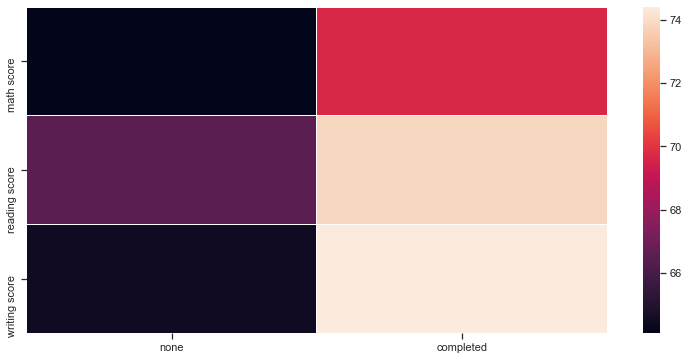

In [20]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(data_prep, linewidths=.1, ax=ax)

Очевидно, что ученики, готовивишиеся к экзаменам, сдают их лучше. Хотя и разница в баллах, на удивление, не сильно большая

# 4) Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

Введем новый признак, который и станет целевым, показывающий сдал ли ученик экзамен по математике. Будем считать экзамен сданным, если набрано более половины возможных баллов ( >50)

In [21]:
data['math passed'] = data['math score'].apply(lambda x: 1 if x > 50 else 0)

In [22]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math passed
0,female,group B,bachelor's degree,standard,none,72,72,74,1
1,female,group C,college,standard,completed,69,90,88,1
2,female,group B,master's degree,standard,none,90,95,93,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,0
4,male,group C,college,standard,none,76,78,75,1


Для построения модели будем использовать все признаки, кроме math score, т.к. по сути из него и получен предсказываемых признак.

Выполним масштабирование баллов

In [23]:
# Числовые колонки для масштабирования
scale_cols = ['math score', 'reading score', 'writing score']

sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [24]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math passed,math score_scaled,reading score_scaled,writing score_scaled
0,female,group B,bachelor's degree,standard,none,72,72,74,1,0.72,0.662651,0.711111
1,female,group C,college,standard,completed,69,90,88,1,0.69,0.879518,0.866667
2,female,group B,master's degree,standard,none,90,95,93,1,0.90,0.939759,0.922222
3,male,group A,associate's degree,free/reduced,none,47,57,44,0,0.47,0.481928,0.377778
4,male,group C,college,standard,none,76,78,75,1,0.76,0.734940,0.722222


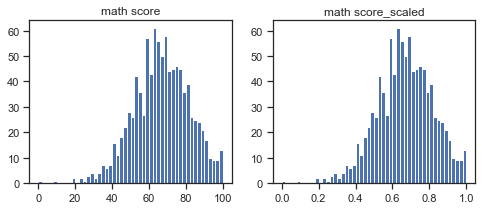

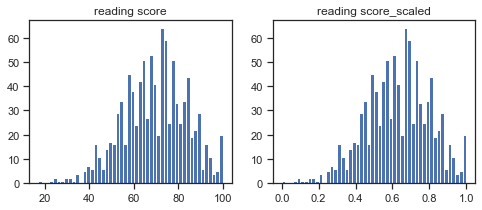

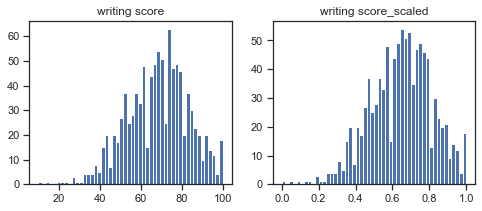

In [25]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

Произведем кодирование категориальных признаков

In [26]:
# Оставляем только необходимые столбцы
classification_data = data.copy()
classification_data = classification_data.drop(columns = ['math score', 'reading score', 'writing score', 'math score_scaled'])
classification_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math passed,reading score_scaled,writing score_scaled
0,female,group B,bachelor's degree,standard,none,1,0.662651,0.711111
1,female,group C,college,standard,completed,1,0.879518,0.866667
2,female,group B,master's degree,standard,none,1,0.939759,0.922222
3,male,group A,associate's degree,free/reduced,none,0,0.481928,0.377778
4,male,group C,college,standard,none,1,0.734940,0.722222


In [27]:
text_cols = [
  'gender'
, 'race/ethnicity'
, 'parental level of education'
, 'lunch'
, 'test preparation course'] 

classification_data = pd.get_dummies(classification_data, columns=text_cols)
classification_data.head()

,math passed,reading score_scaled,writing score_scaled,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_college,parental level of education_high school,parental level of education_master's degree,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,1,0.662651,0.711111,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,1,0.879518,0.866667,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0
2,1,0.939759,0.922222,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1
3,0,0.481928,0.377778,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
4,1,0.734940,0.722222,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1


In [28]:
print(classification_data[classification_data['math passed'] == 0].shape[0]
    , classification_data[classification_data['math passed'] == 1].shape[0])

150 850


Видим, что присутсвует дисбаланс классов в math passed. Исправим это - проведем оверсэмплинг

In [29]:
data_pass = classification_data[classification_data['math passed'] == 1]
data_fail = classification_data[classification_data['math passed'] == 0]

fail_n = classification_data[classification_data['math passed'] == 0].shape[0]
pass_n = classification_data[classification_data['math passed'] == 1].shape[0]
times_x = np.floor(pass_n / fail_n)
diff = int(pass_n - times_x * fail_n)

print(times_x, diff)

5.0 100


In [30]:
classification_data = pd.concat([data_pass, 
                            data_fail,
                            data_fail,
                            data_fail,
                            data_fail,
                            data_fail,
                            data_fail.sample(diff, random_state = 999)])
print(classification_data[classification_data['math passed'] == 0].shape[0]
    , classification_data[classification_data['math passed'] == 1].shape[0])

850 850


# 5)Выбор метрик для последующей оценки качества моделей.

В качестве метрик для решения задачи классификации будем использовать метрики, формируемые на основе матрицы ошибок: <br>
<b>precision</b> - Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные <br>
<b>recall</b> - Доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов <br>
<b>F1 -мера</b> - Для того, чтобы объединить precision и recall в единую метрику <br>
<b>Метрика ROC AUC</b> - Идеальная ROC-кривая проходит через точки (0,0)-(0,1)-(1,1), то есть через верхний левый угол графика.Чем сильнее отклоняется кривая от верхнего левого угла графика, тем хуже качество классификации. В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора.
 

In [31]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [32]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value1': pd.Series([], dtype='float'),
            'value2': pd.Series([], dtype='float')})

    def add(self, metric, alg, value, case):
        """
        Добавление значения
        """
        if (case == 1):
            temp = [{'metric':metric, 'alg':alg, 'value1':value}]
            self.df = self.df.append(temp, ignore_index=True)
        else:
            temp = [{'metric':metric, 'alg':alg, 'value2':value}]
            self.df = self.df.append(temp, ignore_index=True)
        
    def get_data_for_metric(self, metric, case, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        if (case == 1):
            temp_data = self.df[self.df['metric']==metric]
            temp_data_2 = temp_data.sort_values(by='value1', ascending=ascending)
            temp_data_2 = temp_data_2[temp_data_2['value2'].isnull()]
            return temp_data_2['alg'].values, temp_data_2['value1'].values
        else:
            temp_data = self.df[self.df['metric']==metric]
            temp_data_2 = temp_data.sort_values(by='value2', ascending=ascending)
            temp_data_2 = temp_data_2[temp_data_2['value1'].isnull()]

            return temp_data_2['alg'].values, temp_data_2['value2'].values
    
    def plot(self, str_header, metric, case, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, case, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show() 

# 6) Выбор наиболее подходящих моделей для решения задачи классификации или регрессии.

Для нашей задачи классификации будем использовать следующие модели: <br>
1) Логистическая регрессия<br>
2) Метод ближайших соседей<br>
3) Машина опорных векторов<br>
4) Решающее дерево<br>
5) Случайный лес<br>
6) Градиентный бустинг<br>

# 7) Формирование обучающей и тестовой выборок на основе исходного набора данных.

Сделаем две выборки, чтобы предсказывать сдаст ли ученик экзамен по математике, зная его баллы за другие экзамены (X1, y1) и не зная (X2, y2)

In [33]:
X1 = classification_data.loc[:, classification_data.columns != 'math passed']
y1 = classification_data['math passed']

scores = ['math passed', 'reading score_scaled', 'writing score_scaled']
select = [x for x in classification_data.columns if x not in scores]
X2 = classification_data.loc[:, select]
y2 = classification_data['math passed']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.33, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, random_state = 42)

# 8) Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

In [34]:
# Модели
clas_models = {'LogR': LogisticRegression(), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'SVC':SVC(),
               'Tree':DecisionTreeClassifier(),
               'RF':RandomForestClassifier(),
               'GB':GradientBoostingClassifier()}

In [35]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [36]:
def clas_train_model(model_name, model, clasMetricLogger, case):
    if (case == 1):
        X_train, y_train, X_test, y_test = X1_train, y1_train, X1_test, y1_test
    else:
        X_train, y_train, X_test, y_test = X2_train, y2_train, X2_test, y2_test
        
        
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test.values, y_pred)
    recall = recall_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred)
    roc_auc = roc_auc_score(y_test.values, y_pred)
    
    clasMetricLogger.add('precision', model_name, precision, case)
    clasMetricLogger.add('recall', model_name, recall, case)
    clasMetricLogger.add('f1', model_name, f1, case)
    clasMetricLogger.add('roc_auc', model_name, roc_auc, case)

    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(y_test.values, y_pred)
    
    plot_confusion_matrix(model, X_test, y_test.values, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

Первый случай - знаем баллы за другие экзамены:

*****************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


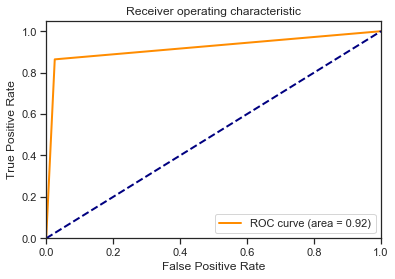

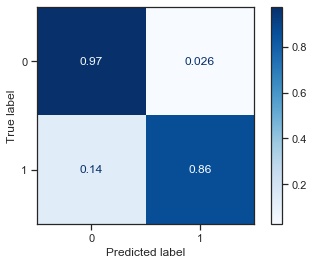

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*****************************************************


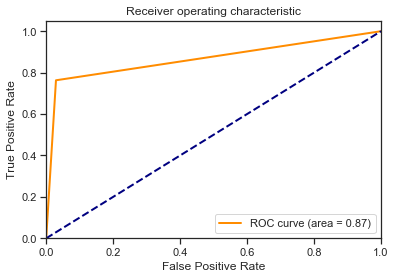

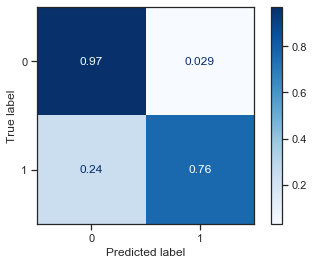

*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


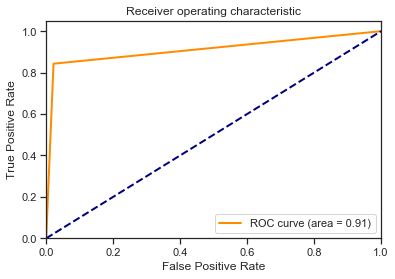

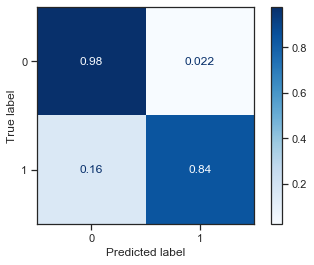

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************


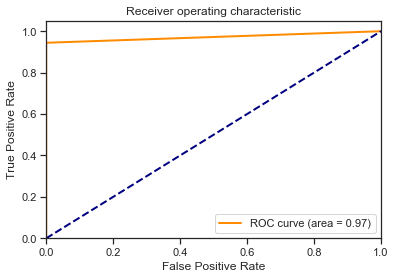

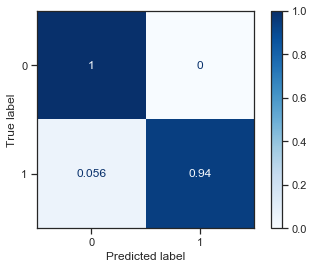

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
*****************************************************


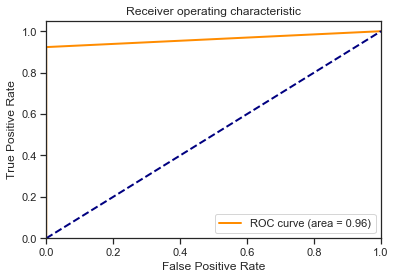

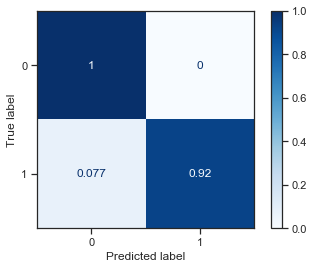

*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************


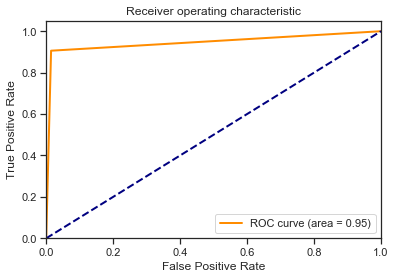

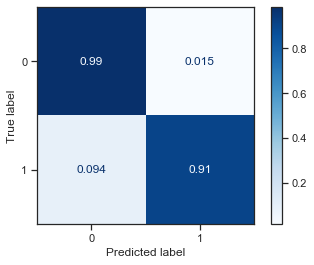

In [37]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger, case = 1)

Второй случай - знаем только общую информацию об ученике:

*****************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
*****************************************************


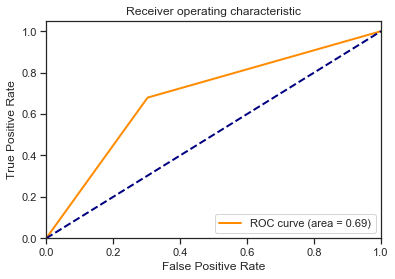

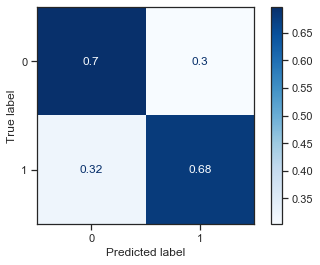

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*****************************************************


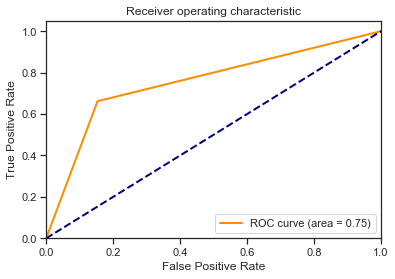

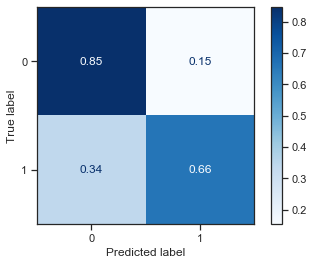

*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


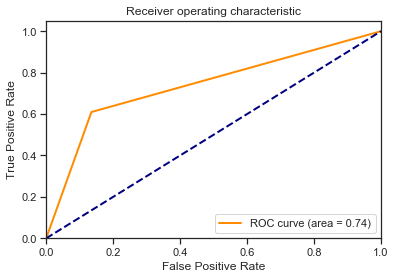

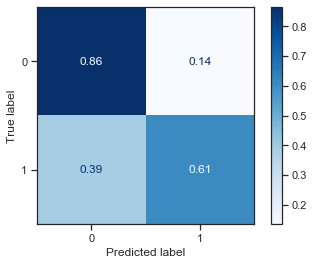

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************


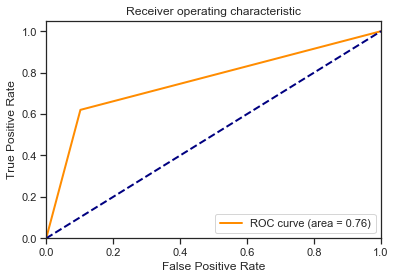

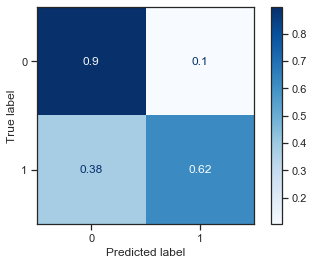

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
*****************************************************


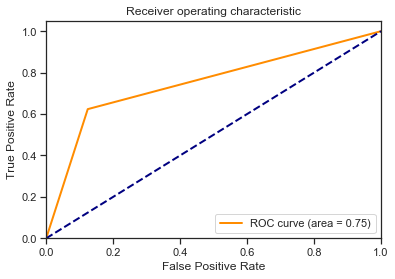

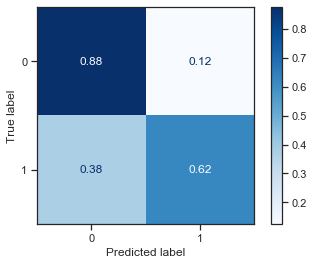

*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************


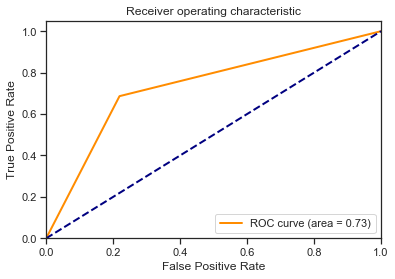

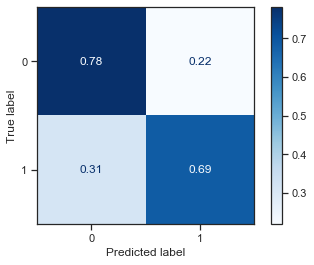

In [38]:
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger, case = 2)

# 9) Подбор гиперпараметров для выбранных моделей.

Будем рассматривать только первый случай. В нем хуже всего себя вели модели метода ближайших соседей и машины опорных векторов. Подберем для них гиперпараметры.

In [39]:
knn_range = np.array(range(1,900,10))
tuned_parameters = [{'n_neighbors': knn_range}]
tuned_parameters

[{'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
         131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
         261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
         391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
         521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641,
         651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771,
         781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891])}]

In [40]:
knn_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='roc_auc')
knn_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
       521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641,
       651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771,
       781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891])}],
             pre_dispatch='2*n_

In [41]:
# Лучшая модель
knn_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [42]:
# Лучшее значение параметров
knn_gs.best_params_

{'n_neighbors': 1}

In [43]:
svc_range = np.array(np.arange(0, 1.1 ,0.1))
tuned_parameters = [{'gamma': svc_range}]
tuned_parameters

[{'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

In [44]:
svc_gs = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='roc_auc')
svc_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [45]:
# Лучшая модель
svc_gs.best_estimator_

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.4, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
# Лучшее значение параметров
svc_gs.best_params_

{'gamma': 0.4}

Подберем также гиперпараметры для этих же моделей на выборке второго случая. Посмотрим, изменятся ли они.

In [ ]:
knn_gs.fit(X2_train, y2_train)

In [ ]:
# Лучшая модель
knn_gs.best_estimator_

In [ ]:
# Лучшее значение параметров
knn_gs.best_params_

In [ ]:
svc_gs.fit(X1_train, y1_train)

In [ ]:
# Лучшая модель
svc_gs.best_estimator_

In [ ]:
# Лучшее значение параметров
svc_gs.best_params_

Получили другое значение для метода ближайших соседей. Запомним и его

# 10) Повторение пункта 8 для найденных оптимальных значений гиперпараметров. Сравнение качества полученных моделей с качеством baseline-моделей.

Первый случай - знаем баллы за другие экзамены:

In [ ]:
# Модели c подобранными гиперпараметрами
clas_models = {'KNN_1':KNeighborsClassifier(n_neighbors=1),
               'SVC_0.4':SVC(gamma=0.4)}

for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger, case = 1)

Второй случай - знаем только общую информацию об ученике:

In [ ]:
# Модели c подобранными гиперпараметрами
clas_models = {'KNN_11':KNeighborsClassifier(n_neighbors=11),
               'SVC_0.4':SVC(gamma=0.4)}

for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger, case = 2)

В обоих случаях (в первом особенно) подбор гиперпараметров помог улучшить модели

# 11) Формирование выводов о качестве построенных моделей на основе выбранных метрик.

In [ ]:
# Метрики качества модели
clas_metrics = clasMetricLogger.df['metric'].unique()
clas_metrics

Первый случай - предсказываем сдаст ли экзамен по математике, зная баллы за другие экзамены:

In [ ]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6), case = 1)

На основании всех четырех метрик видим, что тройка лучших моделей - это решающее дерево, случайный лес и метод ближайших соседей с подобранным гиперпараметром. <b>Наиболее предпочтителльная модель для предсказания - решающее дерево.

Второй случай - знаем только общую информацию об ученике:

In [ ]:
# Построим графики метрик качества модели
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6), case = 2)

На основании трех метрик из 4-х <b>считаем наиболее предпочтительной моделью для предсказания машину опорных векторов с подобранным гиперпараметром.</b> Возможно, если бы подбирались гиперпараметры и для других моделей, выбор бы изменился.


Итог: Зная результаты других экзаменов, можно предсказать сдаст ли ученик экзамен по математике с очень высокой точностью. Без знания о баллах по другим экзаменам предсказывать сложнее, но результаты получаются тоже достаточно неплохими.